In [1]:
# LB Score = 0.83793

In [2]:
import time
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler

In [3]:
def prepare_submit(model, x_test, file_name = 'submission'):
    y_test_pred= model.predict_proba(X_test)[:, 1]
    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    df_submission.to_csv(file_name)

In [4]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [5]:
train = pd.read_csv('data/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('data/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('data/test_features.csv', index_col='match_id_hash')

In [6]:
split_index = train.shape[0]

In [7]:
df = pd.concat([train, test], sort=False)

In [8]:
df.shape

(49675, 245)

In [9]:
r_gold_columns = [col for col in df if col.endswith('gold')][:5]
d_gold_columns = [col for col in df if col.endswith('gold')][5:]
df['r_gold_mean'] = df[r_gold_columns].mean(axis = 1)
df['r_gold_std'] = df[r_gold_columns].std(axis = 1)
df['r_gold_total'] = df[r_gold_columns].sum(axis = 1)
df['d_gold_mean'] = df[d_gold_columns].mean(axis = 1)
df['d_gold_std'] = df[d_gold_columns].std(axis = 1)
df['d_gold_total'] = df[d_gold_columns].sum(axis = 1)
df['gold_prop'] = df['d_gold_total'] / df['r_gold_total']
df['gold_prop1'] = df['r_gold_total'] / df['d_gold_total']

In [10]:
train = df[:split_index].copy()

In [11]:
test = df[split_index:].copy()

In [12]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [13]:
train['radiant_win'] = target['radiant_win']

Fold 0 started at Sat Oct 12 18:46:25 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.876305	valid_1's auc: 0.818686
[2000]	training's auc: 0.918554	valid_1's auc: 0.823455
[3000]	training's auc: 0.948532	valid_1's auc: 0.825491
[4000]	training's auc: 0.969585	valid_1's auc: 0.826499
Early stopping, best iteration is:
[4013]	training's auc: 0.969778	valid_1's auc: 0.826525
Fold 1 started at Sat Oct 12 18:46:42 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.879021	valid_1's auc: 0.806445
[2000]	training's auc: 0.920739	valid_1's auc: 0.810176
[3000]	training's auc: 0.950226	valid_1's auc: 0.81149
Early stopping, best iteration is:
[3124]	training's auc: 0.953206	valid_1's auc: 0.811659
Fold 2 started at Sat Oct 12 18:46:56 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.87545	valid_1's auc: 0.821979
[2000]	training's auc: 0.918569	valid_1's auc: 0.826088
[

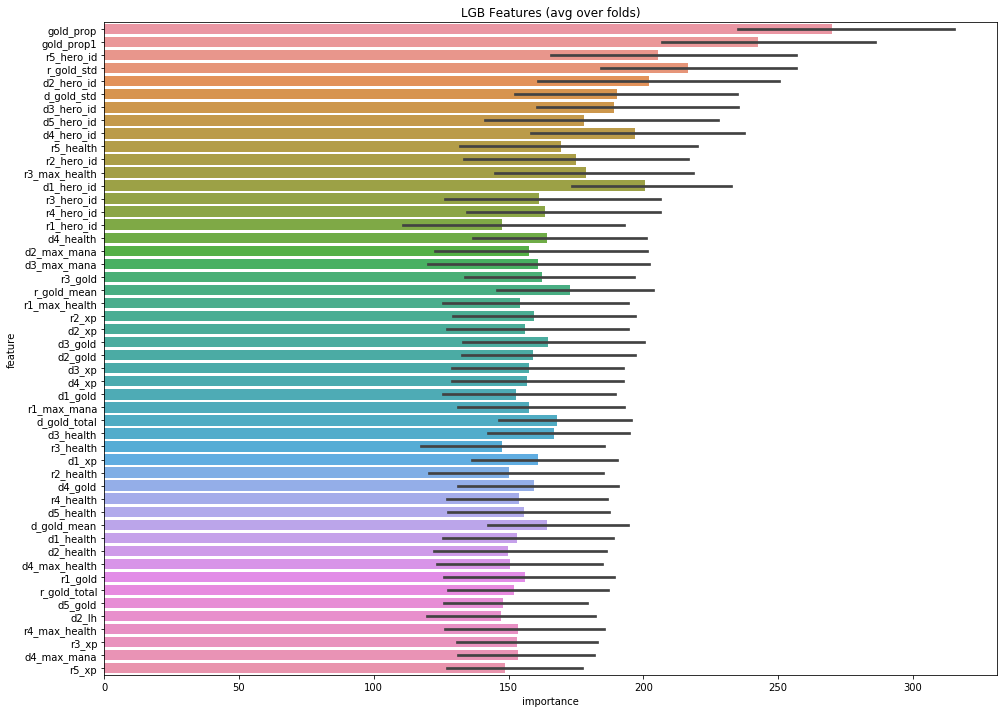

In [14]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = target['radiant_win']
X_test = test.reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [15]:
CV mean score: 0.8154, std: 0.0055

SyntaxError: invalid syntax (<ipython-input-15-00d0b42ab2eb>, line 1)

In [ ]:
#prepare_submit(rf, X_test, 'submission3.csv')